## 1. usa.gov data from bit.ly

In [1]:
import json

path = '/home/flexai/git/pydata-book/datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

In [2]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [3]:
records[0]['tz']

'America/New_York'

In [5]:
print(records[0]['tz'])

America/New_York


### Counting Time Zones with pure python

In [6]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

In [7]:
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

In [8]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

In [9]:
from collections import defaultdict

def get_counts2(sequence):
    counts = defaultdict(int) # values will initialize to 0
    for x in sequence:
        counts[x] += 1
    return counts

In [10]:
counts = get_counts(time_zones)
counts['America/New_York']

1251

In [11]:
len(time_zones)

3440

In [12]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [13]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

In [14]:
from collections import Counter
counts = Counter(time_zones)
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

### Counting Time Zones with pandas


In [15]:
from pandas import DataFrame, Series
import pandas as pd

frame = DataFrame(records)
frame

,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1.331823e+09,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1.331923e+09,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,NaN,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1.308262e+09,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.0,http://www.AwareMap.com/,1.331923e+09,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,NaN,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1.331920e+09,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.0,http://t.co/03elZC4Q,1.331923e+09,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.0,direct,1.331923e+09,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1.273672e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...
5,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,axNK8c,MA,axNK8c,1.273673e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...
6,NaN,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.1...,"pl-PL,pl;q=0.8,en-US;q=0.6,en;q=0.4",PL,Luban,wcndER,77,zkpJBR,1.331923e+09,1.usa.gov,NaN,bnjacobs,"[51.116699, 15.2833]",0.0,http://plus.url.google.com/url?sa=z&n=13319232...,1.331923e+09,Europe/Warsaw,http://www.nasa.gov/mission_pages/nustar/main/...
7,NaN,Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/2...,"bg,en-us;q=0.7,en;q=0.3",None,NaN,wcndER,NaN,zkpJBR,1.331923e+09,1.usa.gov,NaN,bnjacobs,NaN,0.0,http://www.facebook.com/,1.331923e+09,,http://www.nasa.gov/mission_pages/nustar/main/...
8,NaN,Opera/9.80 (X11; Linux zbov; U; en) Presto/2.1...,"en-US, en",None,NaN,wcndER,NaN,zkpJBR,1.331923e+09,1.usa.gov,NaN,bnjacobs,NaN,0.0,http://www.facebook.com/l.php?u=http%3A%2F%2F1...,1.331923e+09,,http://www.nasa.gov/mission_pages/nustar/main/...
9,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"pt-BR,pt;q=0.8,en-US;q=0.6,en;q=0.4",None,NaN,zCaLwp,NaN,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,NaN,0.0,http://t.co/o1Pd0WeV,1.331923e+09,,http://apod.nasa.gov/apod/ap120312.html


In [16]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

In [17]:
tz_counts = frame['tz'].value_counts()

In [18]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

In [22]:
# Fill missing (NA) values with 'Missing'
clean_tz = frame['tz'].fillna('Missing')

# Replace unknown (empty string) values by boolean array indexing
clean_tz[clean_tz == ''] = 'Unknown'

In [23]:
tz_counts = clean_tz.value_counts()

tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

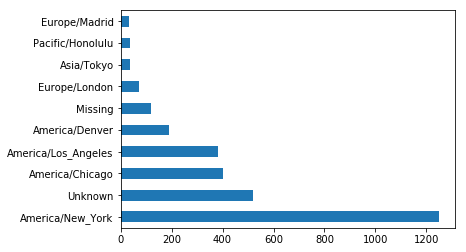

In [25]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

tz_counts[:10].plot(kind='barh', rot=0)

In [26]:
results = Series([x.split()[0] for x in frame.a.dropna()])
results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [27]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

In [28]:
cframe = frame[frame.a.notnull()]

In [29]:
operating_system = np.where(cframe['a'].str.contains('Windows'),
                            'Windows', 'Not Windows')
operating_system[:5]

array(['Windows', 'Not Windows', 'Windows', 'Not Windows', 'Windows'],
      dtype='<U11')

In [30]:
by_tz_os = cframe.groupby(['tz', operating_system])

In [31]:
agg_counts = by_tz_os.size().unstack().fillna(0)

agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


In [32]:
# Use to sort in ascending order
indexer = agg_counts.sum(1).argsort()

indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

In [33]:
count_subset = agg_counts.take(indexer)[-10:]

count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


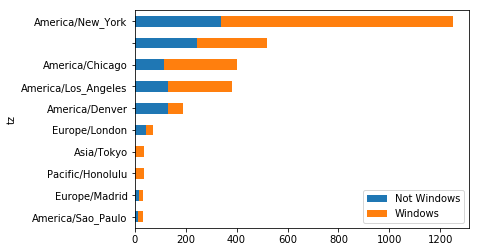

In [34]:
count_subset.plot(kind='barh', stacked=True)

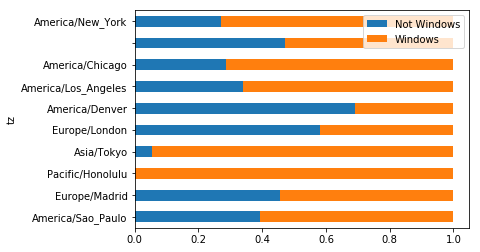

In [35]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

normed_subset.plot(kind='barh', stacked=True)

## 2. MovieLens 1M Data Set

In [36]:
import pandas as pd

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('/home/flexai/git/pydata-book/datasets/movielens/users.dat', sep='::',
                      header=None, names=unames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/home/flexai/git/pydata-book/datasets/movielens/ratings.dat', sep='::',
                        header=None, names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('/home/flexai/git/pydata-book/datasets/movielens/movies.dat', sep='::',
                       header=None, names=mnames)

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


In [37]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [38]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [39]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [41]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


In [42]:
data = pd.merge(pd.merge(ratings, users), movies)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
user_id       1000209 non-null int64
movie_id      1000209 non-null int64
rating        1000209 non-null int64
timestamp     1000209 non-null int64
gender        1000209 non-null object
age           1000209 non-null int64
occupation    1000209 non-null int64
zip           1000209 non-null object
title         1000209 non-null object
genres        1000209 non-null object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


In [43]:
data.ix[0]

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

In [49]:
mean_ratings = data.pivot_table(values='rating', index="title", columns='gender', aggfunc='mean')
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [51]:
ratings_by_title = data.groupby('title').size()

ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [52]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [53]:
mean_ratings = mean_ratings.ix[active_titles]

mean_ratings

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
"13th Warrior, The (1999)",3.112000,3.168000
2 Days in the Valley (1996),3.488889,3.244813
"20,000 Leagues Under the Sea (1954)",3.670103,3.709205
2001: A Space Odyssey (1968),3.825581,4.129738


In [54]:
top_females_ratings = mean_ratings.sort_index(by='F', ascending=False)

top_females_ratings[:10]

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


### Measuring rating disagreement

In [55]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

sorted_by_diff = mean_ratings.sort_index(by='diff')
sorted_by_diff[:15]

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


In [56]:
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


In [57]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()

In [58]:
# Filter down to active_titles
rating_std_by_title = rating_std_by_title.ix[active_titles]

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [61]:
# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## 3. US Baby Names 1800-2010

In [63]:
import pandas as pd

yob1880 = '/home/flexai/git/pydata-book/datasets/babynames/yob1880.txt'
names1880 = pd.read_csv(yob1880, names=['name', 'sex', 'births'])

names1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
name      2000 non-null object
sex       2000 non-null object
births    2000 non-null int64
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [65]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [66]:
# 2010 is the last available year right now
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = '/home/flexai/git/pydata-book/datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)
    
# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 4 columns):
name      1690784 non-null object
sex       1690784 non-null object
births    1690784 non-null int64
year      1690784 non-null int64
dtypes: int64(2), object(2)
memory usage: 51.6+ MB


In [67]:
total_births = names.pivot_table(values='births', index='year', columns='sex', aggfunc=sum)
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


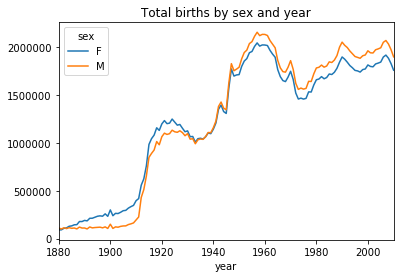

In [68]:
total_births.plot(title='Total births by sex and year')

In [69]:
def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)
    
    group['prop'] = births / births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690784 entries, 0 to 1690783
Data columns (total 5 columns):
name      1690784 non-null object
sex       1690784 non-null object
births    1690784 non-null int64
year      1690784 non-null int64
prop      1690784 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 64.5+ MB


In [70]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

In [72]:
def get_top1000(group):
    return group.sort_index(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  


In [74]:
pieces = []
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_index(by='births', ascending=False)[:1000])
newtop1000 = pd.concat(pieces, ignore_index=True)

/home/flexai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
top1000.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 261877 entries, (1880, F, 0) to (2010, M, 1677645)
Data columns (total 5 columns):
name      261877 non-null object
sex       261877 non-null object
births    261877 non-null int64
year      261877 non-null int64
prop      261877 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 13.7+ MB


In [76]:
newtop1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261877 entries, 0 to 261876
Data columns (total 5 columns):
name      261877 non-null object
sex       261877 non-null object
births    261877 non-null int64
year      261877 non-null int64
prop      261877 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 10.0+ MB


### Analyzing Naming Trends